In [11]:
#this script can be used to identify single networks

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
# miRNA edges chord diagram can be accessed -> self constructed Database
chord_diagram = pd.read_csv("miRNA_edges2")
mirna_network = chord_diagram[chord_diagram["correlation"] <
                              -0.7]  # only highly negative correlated miRNAs
string_interaction = pd.read_csv(
    "string_hsa_preprocess.csv")  # read the string file
string_interaction["score"] = string_interaction["combined_score"].apply(
    lambda x: x / 1000)  # only protein-protein interactions above 0.9
string_interaction_high = string_interaction.loc[
    string_interaction["score"] >= 0.9]
mirna_network = mirna_network[mirna_network["score"] > 75]

In [8]:
# defined file to get the string interactions
# frozenset was apllied to remove duplicated string gene:gene interaction since it is a bilateral interaction
# this can remove computational effort


def string_from_file(genes_liste, string):
    string_network = string[string["preferred_name_x"].isin(genes_liste)]
    string_end = string_network[string_network["preferred_name_y"].isin(
        genes_liste)]
    string_end = string_end.drop(["Unnamed: 0"], axis=1)
    string_end = string_end[
        ~string_end[['preferred_name_x', 'preferred_name_y']].
        apply(frozenset, 1).duplicated()]
    string_end["score"] = string_end["score"].apply(lambda x: x * 200)
    print(string_end)
    return string_end

         preferred_name_x preferred_name_y  combined_score  score
82579               STRAP           MAP3K7             904  180.8
101325              CPSF4           PPP1CA             914  182.8
312457               RFC2            UBE2T             918  183.6
312653             TOPBP1            UBE2T             921  184.2
312770              FANCM            UBE2T             977  195.4
...                   ...              ...             ...    ...
10531157            TUBG1           CEP192             917  183.4
10547852            CENPQ             NSL1             906  181.2
10547931            CENPN             NSL1             903  180.6
10645152           ELAVL1            SNRPC             943  188.6
11439388            CENPQ            CENPN             989  197.8

[606 rows x 4 columns]


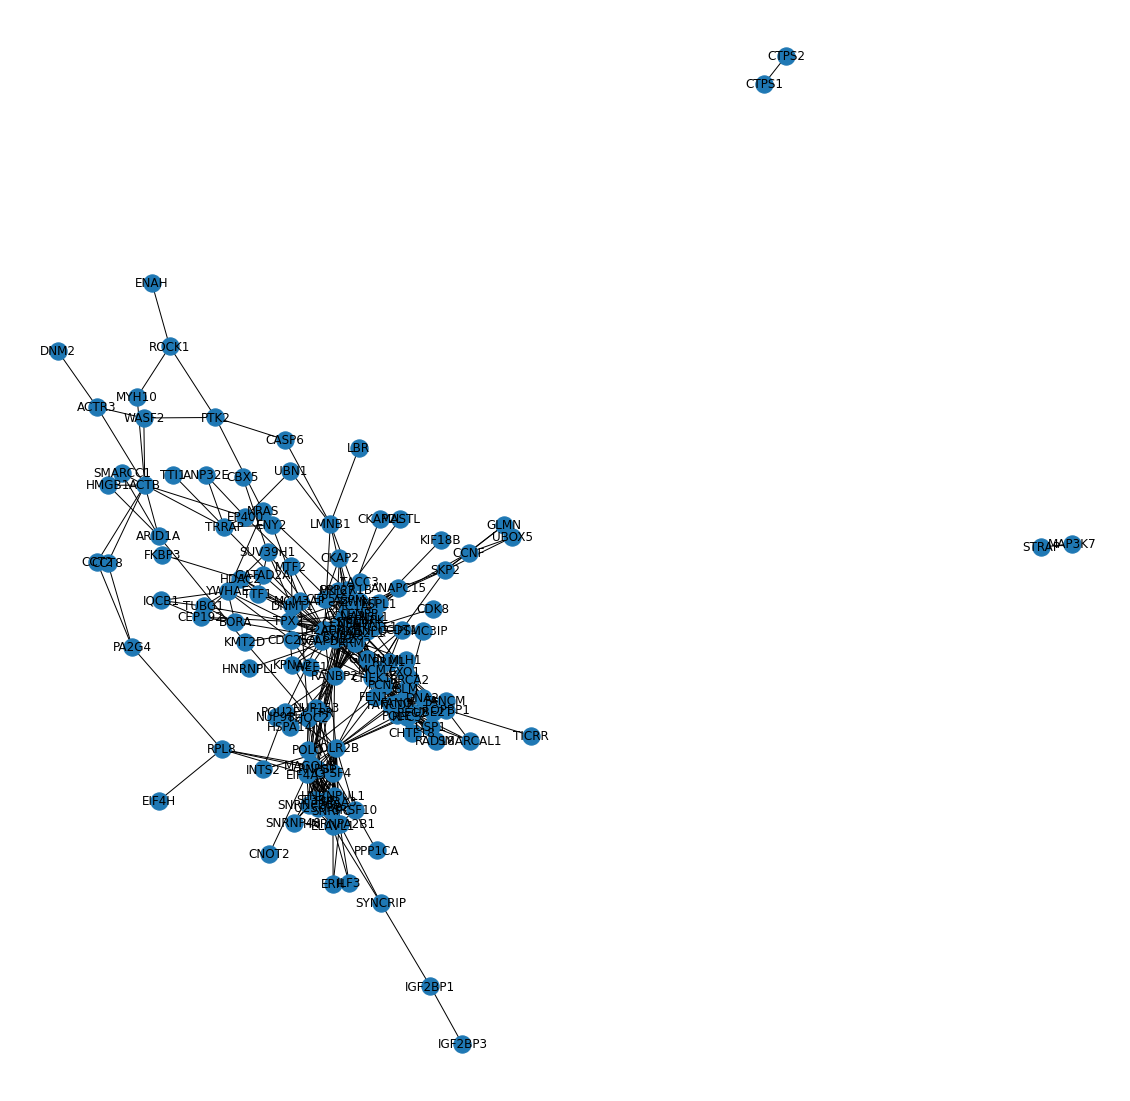

In [44]:
# find the potential miRNA interaction networks
# draw the networks based on the scores
def miRNA_network(string, chord_file, label):
    mirna_network = chord_file[chord_file["mirna"].str.contains(label)]
    genes_liste = mirna_network["gene_name"].tolist()
    interaction = string_from_file(genes_liste, string)
    network_edge = nx.from_pandas_edgelist(interaction, "preferred_name_x",
                                           "preferred_name_y",
                                           "combined_score")
    node_score = {}
    node_community = {}
    for node in network_edge.nodes:
        node_attribute = mirna_network[mirna_network["gene_name"] == node]
        node_score.update({str(node): node_attribute["score"].tolist()[0]})
        node_community.update(
            {str(node): node_attribute["supercluster_gene"].tolist()[0]})
        #node_stage_value.append(node_attribute["supercluster_gene"].tolist()[0])
        #node_score_value.append(node_attribute["score"].tolist()[0])
    nx.set_node_attributes(network_edge, node_score, "score")
    nx.set_node_attributes(network_edge, node_community, "supercluster")
    nx.write_graphml(network_edge, label + "network_enrichements.xml")
    fig, ax = plt.subplots(figsize=(20, 20))
    nx.draw_spring(network_edge, with_labels=True)


miRNA_network(string_interaction_high, mirna_network, "hsa-let-7c-5p")